In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os.path as path
from copy import deepcopy
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from collections import defaultdict
from fuzzywuzzy import fuzz

In [2]:
DATA_DIR = "new_data/"
OBJ_DIR = "serialized_obj/"

In [3]:

def store_obj(obj, filename):
    file_path = path.join(OBJ_DIR, filename)
    print("Storing", file_path)
    with open(file_path, "wb") as f:
        pickle.dump(obj, f)

def load_obj(filename):
    file_path = path.join(OBJ_DIR, filename)
    print("Loading", file_path)
    with open(file_path, "rb") as f:
        obj = pickle.load(f)
    return obj

def get_num_leaves(g, nid):
    visited = set()
    return get_num_leaves_support(g, nid, visited)

def get_num_leaves2(g, nids):
    visited = set()
    s = 0
    for nid in nids:
        s += get_num_leaves_support(g, nid, visited)
    return s

def get_num_leaves_support(g, nid, visited):
    visited.add(nid)
    # print (cat_id_to_name[nid],)
    if nid not in g:
        return 1
    s = 0
    for i in g[nid]:
        if i not in visited:
            s += get_num_leaves_support(g, i, visited)
    return s


def get_max_depth(g, nid):
    visited = set()
    # print("\n-----")
    return get_max_depth_support(g, nid, visited)

def get_max_depth_support(g, nid, visited):
    visited.add(nid)
    if nid not in g:
        return 1
    s = 0
    for i in g[nid]:
        if i not in visited:
            d = get_max_depth_support(g, i, visited)
            if d > s:
                s = d
    return s + 1

def get_num_children(g, nid):
    visited = set()
    # print("\n-----")
    return get_num_children_support(g, nid, visited)


def get_num_children_support(g, nid, visited):
    visited.add(nid)
    if nid not in g:
        return 1
    s = 0
    for i in g[nid]:
        if i not in visited:
            s += get_num_children_support(g, i, visited)
    return s + 1

def get_num_pages(g, cat_id_to_pages, nid):
    visited = set()
    return get_num_pages_support(g, cat_id_to_pages, nid, visited)

def get_num_pages_support(g, cat_id_to_pages, nid, visited):
    visited.add(nid)
    if nid not in g:
        return cat_id_to_pages[nid]
    s = 0
    for i in g[nid]:
        if i not in visited:
            s += get_num_pages_support(g, cat_id_to_pages, i, visited)
    return s + cat_id_to_pages[nid]

In [33]:

def get_category_weight(g, cat_id):
    return get_num_leaves(g, cat_id)

def get_categories_avg_weight(g, cat_ids):
    return get_num_leaves2(g, cat_ids)

def get_category_norm_weight(g, g_inv, cat_id):
    parent_cats = g_inv[cat_id]
    parent_values = [get_num_leaves(g, p_cat_id) for p_cat_id in parent_cats]
    value = get_num_leaves(g, cat_id)
    s = sum(parent_values)
    if s:
        return value/s
    else:
        return s

def get_category_pages_weight(g, g_inv, cat_id_to_pages, cat_id):
    return get_num_pages(g, cat_id_to_pages, cat_id)

def get_category_pages_norm_weight(g, g_inv, cat_id_to_pages, cat_id):
    parent_cats = g_inv[cat_id]
    parent_values = [get_num_pages(g, cat_id_to_pages, p_cat_id) for p_cat_id in parent_cats]
    value = get_num_pages(g, cat_id_to_pages, cat_id)
    s = sum(parent_values)
    if s:
        return value/s
    else:
        return s

def get_category_pre_pages_norm_weight(g, g_inv, id_to_total_pages, cat_id):
    parent_cats = g_inv[cat_id]
    parent_values = [id_to_total_pages[p_cat_id] for p_cat_id in parent_cats]
    value = id_to_total_pages[cat_id]
    s = sum(parent_values)
    if s:
        return value/s
    else:
        return s

def get_article_avg_weight(search, g, title):
    results = search_article_title(search, title)
    # print(results)
    s = []
    s_score = 0
    for r in results:
        score, title, cat_list = r
        s_score += score
        cat_weight = get_categories_avg_weight(g, cat_list)
        print(cat_weight)
        article_weight = score*cat_weight
        s.append(article_weight)
    top_weights = sorted(s, reverse=True)[0:3]
    return sum(top_weights)/len(top_weights)/s_score

def get_article_weight_gen(search, title, weight_method, argv):
    results = search_article_title(search, title)
    # results = reselect_candidate(results)
    # for _, name, _ in results:
    #     print("Candidate:", name)
    s = 0
    s_score = 0
    for r in results:
        score, article_id, title, cat_list = r
        s_score += score
        if isinstance(weight_method, dict):
            cat_weights = [weight_method[cat_id] for cat_id in cat_list]
        else:
            cat_weights = [weight_method(*argv, cat_id) for cat_id in cat_list]
        print(cat_weights)
        article_weight = score*sum(cat_weights)/len(cat_weights)
        # article_weight = score*sum(cat_weights)
        s += article_weight
    if s:
        s = s/len(results)/s_score
    return s

def search_article_title(search, title):
    s = search.query("match", title=title)[0:5]
    response = s.execute()
    rt = []
    for h in response:
        rt.append([h.meta.score, h.id, h.title, h.category_list])
        print(h.meta.score, h.id, h.title, h.category_list)
    return rt

def DFS_support(cat_id, g, depth, visited):
    if cat_id in visited:
        return
    if depth == 0:
        return
    visited.add(cat_id)
    for cat in g[cat_id]:
        if cat not in visited:
            DFS_support(cat, g, depth-1, visited)

def DFS(cats, g, depth):
    visited = set()
    for cat in cats:
        DFS_support(cat, g, depth, visited)
    return visited

def mark_component(i, c, connected, marked):
    marked[i] = c
    for j in range(i+1, len(connected)):
        if connected[i, j] == 1:
            mark_component(j, c, connected, marked)

def get_component_index(candidates):
    global g, ginv, id_to_total_pages, id_to_total_leaves
    n = len(candidates)
    connected = np.zeros((n, n))
    reachable = []
    for i in range(n):
        reachable.append(DFS(candidates[i], g, 3) | DFS(candidates[i], ginv, 3) )
    for i in range(n-1):
        for j in range(i+1, n):
            connected[i, j] = 1 if len(reachable[i] & reachable[j]) != 0 else 0
    marked = {}
    c = 0
    # for cp in connected:
    #     print(cp)
    for i in range(n):
        if i not in marked:
            mark_component(i, c, connected, marked)
            c += 1
    component = defaultdict(list)
    component_weight = defaultdict(int)
    for key, value in marked.items():
        component[value].append(key)
    for cp, index_candidates in component.items():
        for index in index_candidates:
            new_weight = np.sum([id_to_total_leaves[cat] for cat in candidates[index]]) / len(candidates[index])
            component_weight[cp] += new_weight
        component_weight[cp] /= len(index_candidates)
    best_component = None
    best_v = 0
    print(component)
    print(component_weight)
    for cp, value in component_weight.items():
        if best_v < value:
            best_v = value
            best_component = cp
    # best_candidate = None
    # best_v = 0
    # for i in component[best_component]:
    #     value = np.sum([id_to_total_leaves[cat] for cat in candidates[i]]) / len(candidates[i])
    #     if best_v < value:
    #         best_v = value
    #         best_candidate = i
    return component[best_component]

def reselect_candidate(results):
    candidates = [set(results[i][2]) for i in range(len(results))]
    # t = deepcopy(candidates[-1])
    # candidates[-1] = deepcopy(candidates[0])
    # candidates[0] = t
    major_component = get_component_index(candidates)
    new_results = [results[i] for i in major_component]
    print(major_component)
    return new_results    

def plot(terms, weights):
    plt.figure()
    pos = list(range(len(terms)))
    width = 0.25 
    plt.bar(pos, weights, align='center', alpha=0.5)
    plt.xticks(pos, terms)
    plt.ylabel('Capacity')
    plt.title('Capacity of Terms')
    plt.show()

In [37]:

def test_method1(term, weight_dict):
    global term_to_cats, g
    cats = term_to_cats[term]     
    w = np.sum([weight_dict[cat] for cat in cats])/len(cats)
    return w


def get_article_weight_direct(article_id, threshold, article_to_cats, page_id_to_title, cat_id_to_total_leaves):
    cats_id = article_to_cats[article_id]
    title = page_id_to_title[article_id]
    title = title.replace("_", " ")
    print(title, article_id)
    print(cats_id)
    n_found = 0
    avg_weight = 0
    for cat_id in cats_id:
        cat_name = page_id_to_title[cat_id]
        print("cat", cat_name)
        cat_name = cat_name.replace("_", " ")
        if fuzz.ratio(title, cat_name) > threshold:
            print("hit: " + cat_name, cat_id)
            n_found += 1
            avg_weight += cat_id_to_total_leaves[cat_id]
    if n_found:
        avg_weight /= n_found
        return avg_weight
    else:
        return None

def get_article_weight_sibling(article_id, threshold, article_to_cats, page_id_to_title, cat_id_to_total_leaves, cat_to_articles):
    cats_id = article_to_cats[article_id]
    weights = []
    for cat_id in cats_id:
        siblings_id = cat_to_articles[cat_id]
        for sibling_id in siblings_id:
            weight = get_article_weight_direct(sibling_id, threshold, article_to_cats, page_id_to_title, cat_id_to_total_leaves)
            if weight:
                weights.append(weight)
    if len(weights):
        return sum(weights) / len(weights)
    else:
        return None

def get_article_weight(article_id, threshold, article_to_cats, page_id_to_title, cat_id_to_total_leaves, cat_to_articles):
    weight = get_article_weight_direct(article_id, threshold, article_to_cats, page_id_to_title, cat_id_to_total_leaves)
    if not weight:
        weight = get_article_weight_sibling(article_id, threshold, article_to_cats, page_id_to_title, cat_id_to_total_leaves, cat_to_articles)
        if not weight:
            print("miss")
        else:
            print("sibling")
    else:
        print("direct")
    return weight
    
def test(search, term):
    global cat_to_articles, page_id_to_title, cat_id_to_total_leaves, cat_id_to_total_pages
    global term_to_article
    article_id = term_to_article[term]
    return get_article_weight_direct(article_id, 91, article_to_cats, page_id_to_title, cat_id_to_total_leaves)
    
    results = search_article_title(search, term)
    s = 0
    s_score = 0
    for r in results:
        score, article_id, title, cat_list = r
        s_score += score
        weight = get_article_weight(article_id, 91, article_to_cats, page_id_to_title, cat_id_to_total_leaves, cat_to_articles)
        if weight:
            s += score * weight
    if s:
        s = s/len(results)/s_score
    return s

In [5]:
# generate_data()
# exit()

# cat_id_to_title = load_obj("cat_id_to_name.pkl")
# # cat_name_to_id = load_obj("cat_name_to_id.pkl")
# cat_id_to_pages = load_obj("cat_id_to_pages.pkl")
page_id_to_title = load_obj("page_id_to_title.pkl")
article_to_cats = load_obj("article_to_cats.pkl")
cat_to_articles = load_obj("cat_to_articles.pkl")



# cat_id_to_total_pages = load_obj("id_to_total_pages.pkl")
cat_id_to_total_leaves = load_obj("id_to_total_leaves.pkl")

Loading serialized_obj/page_id_to_title.pkl
Loading serialized_obj/article_to_cats.pkl
Loading serialized_obj/cat_to_articles.pkl
Loading serialized_obj/id_to_total_leaves.pkl


In [20]:
g = load_obj("g.pkl")
# ginv = load_obj("ginv.pkl")

Loading serialized_obj/g.pkl


In [38]:
term_to_cats = {"Algorithm":['43940', '54278', '196926', '325876'],
"Database":['106923', '106915'], "Data management":['106883', '166934'],
"Data mining":['106885', '400431'], "Computer science":['119960', '120066', '98251', '98333'],
"Query language": ['98289', '106883', '258574'],
"Big data": ['123602019', '106883', '743619', '321333', '310770'],
"Computational linguistics": ['98150', '636466', '400431', '93505'],
"Speech recognition": ['58504', '98150', '289668', '298942', '61795237', '98195', '243975309'],
"Natural language processing": ['98150', '289668', '215651'],
"Computer vision": ['54377', '163499', '98378', '9451345', '487016'],
"Theoretical computer science": ['325876', '400431'],
"France": ['138197', '160899365', '131216162', '207723004', '140964', '661984', '184699', '72444866', '64719764', '59295209', '243147027', '2319959', '87630896', '265094', '178336766', '246797094'],
"United States": ['297824', '160897546', '121324', '748886', '137358', '207723004', '140964', '661984', '184699', '72444866', '87630896', '265094', '675113', '31739602', '45105775'],
"California": ['79119', '673938', '202244', '219888481', '165471901'],
"Illinois": ['163265', '813494', '675111', '202244', '364820', '76031362'],
"Paris": ['234253', '242485043', '25866894', '371', '91433', '97656', '125125', '139471', '253283', '118407825', '84505', '11472063', '59646016'],
"Beijing": ['65427', '487016', '407645', '234546576', '372', '164918', '200712', '497266'],
"New York": ['218237', '202244', '368401', '219888279', '487016', '74807239', '675126'],
"Chicago": ['246801355', '190618810', '189950652', '190532922', '190533791', '91480', '101553', '162877285', '28949549', '29683106', '487016'],
"Champaign": ['85986', '180780450', '91480', '190532417', '28958260', '304431']}

Algorithm 3733315
[]
Database 40423634
[]
Data management 1015323
['27709243', '34226398', '48814549', '34340246', '20426874', '21988013', '34340409', '41007351', '18766910', '20264633', '34339588', '41007283']
cat Category-Class_Computer_science_articles
cat Category-Class_Database_articles
cat Category-Class_Open_articles
cat NA-Class_Open_access_articles
cat NA-importance_Computer_science_articles
cat NA-importance_Database_articles
cat NA-importance_Open_access_articles
cat NA-importance_Open_articles
cat WikiProject_Computer_science_articles
cat WikiProject_Database_articles
cat WikiProject_Open_Access_articles
cat WikiProject_Open_articles
Data mining 38062867
['27709243', '26504233', '20426874', '24083441', '18766910', '23895349']
cat Category-Class_Computer_science_articles
cat Category-Class_Statistics_articles
cat NA-importance_Computer_science_articles
cat NA-importance_Statistics_articles
cat WikiProject_Computer_science_articles
cat WikiProject_Statistics_articles
Computer

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

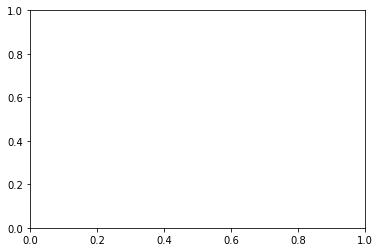

In [39]:

es = Elasticsearch()
search = Search(using=es, index="es-capacity", doc_type="article")

terms1 = ["Cat", "Dog", "Bird", "Plant", "Animal"]
terms2 = ["Algorithm", "Database", "Data management", "Data mining", "Computer science"]
terms3 = ["Query language", "Database", "Data management", "Data mining", "Big data", "Computer science"]
terms4 = ["Database", "Theoretical computer science", "Computer vision", "Natural language processing" , "Speech recognition", "Computational linguistics"]
terms5 = ["Champaign", "Chicago", "New York", "Beijing", "Paris", "Illinois", "California", "United States", "France"]

terms_list = [terms2, terms3, terms4, terms5]

term_to_article = {"Algorithm": "3733315",
"Database": "40423634", "Data management": "1015323",
"Data mining": "38062867", "Computer science": "25031924",
"Query language": "3961120",
"Big data": "48151899",
"Computational linguistics": "38562059",
"Speech recognition": "38562215",
"Natural language processing": "43779661",
"Computer vision": "3966765",
"Theoretical computer science": "17326466",
"France": "37407566",
"United States": "33014499",
"California": "7375185",
"Illinois": "11956271",
"Paris": "4244049",
"Beijing": "37299941",
"New York": "51584461",
"Chicago": "12799998",
"Champaign": "8674577"}

if False:
    term1 = input("Enter Term 1:")
    term2 = input("Enter Term 2:")
    while term1:
        term1 = term1.strip()
        term2 = term2.strip()
        if term1 == "exit":
            exit()
        terms = [term1, term2]
        weights = np.array([get_article_weight_gen(search, term, id_to_total_leaves , None) for term in terms])
        plot(terms, weights)
        print("------------")
        print(terms)
        print(weights)
        print("------------")
        if weights[0] > weights[1]:
            print(term1 , ">", term2)
        elif weights[0] < weights[1]:
            print(term1 , "<", term2)
        else:
            print(term1 , "=", term2)
        term1 = input("Enter Term 1:")
        term2 = input("Enter Term 2:")
    exit()

for terms in terms_list:
    # weights = [get_article_weight_gen(search, term, id_to_total_leaves, None) for term in terms]
    # weights1 = [get_article_avg_weight(search, g, term) for term in terms]
    # weights2 = [get_article_weight_gen(search, term, get_category_weight, [g]) for term in terms]
    # weights3 = [get_article_weight_gen(search, term, get_category_norm_weight, [g, ginv]) for term in terms]
    # weights4 = [get_article_weight_gen(search, term, get_category_pages_weight, [g, ginv, cat_id_to_pages]) for term in terms]
    # weights5 = [get_article_weight_gen(search, term, get_category_pages_norm_weight, [g, ginv, cat_id_to_pages]) for term in terms]
    # weights6 = np.array([get_article_weight_gen(search, term, get_category_pre_pages_norm_weight, [g, ginv, id_to_total_pages]) for term in terms])
    # weights7 = np.array([get_article_weight_gen(search, term, cat_id_to_total_pages, None) for term in terms])
#     weights = np.array([get_article_weight_gen(search, term, cat_id_to_total_leaves , None) for term in terms])
#     weights9 = np.array([test_method1(term, cat_id_to_total_leaves) for term in terms])
    # weights = weights6**0.7 * weights7**0.3
    
    weights = np.array([test(search, term) for term in terms])
    print("------------")
    print(terms)
    print(weights)
    print("------------")
    plot(terms, weights)